In [61]:
from matplotlib.colors import to_rgb
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

class MetricsAnalyzer:
    def __init__(self, halstead_path, loc_path, cc_path):
        self.halstead_path = halstead_path
        self.loc_path = loc_path
        self.cc_path = cc_path
        self.languages = ["cirq", "quapl", "qiskit", "qrisp", "qmod", "q#", "qasm", "classic"]
        self.algorithm_order = ["deutsch-jotza","bernstein-vazirani","simon","grover"]
        self.lang_map = {
            "hosted": ["cirq", "quapl", "qiskit", "qrisp"],
            "standalone": ["q#", "qmod"],
            "all": ["cirq", "quapl", "qiskit", "qrisp", "q#", "qmod"]
        }
        self.df_master = self._build_master_dataframe()
        self.color_map = self._build_color_map()
        

    def _clean_algorithm_name(self, name):
        return re.sub(r"^\d{2}[-_]", "", name)

    def _build_color_map(self, palette_name="Set3"):
        palette = sns.color_palette(palette_name, n_colors=10)
        palette[1] = to_rgb("#FFFF4B")   
        languages = self.languages
        return {lang: palette[i % len(palette)] for i, lang in enumerate(languages)}

    def _build_master_dataframe(self):
        halstead_df = pd.read_csv(self.halstead_path, index_col=0)
        loc_df = pd.read_csv(self.loc_path, index_col=0)
        cc_df = pd.read_csv(self.cc_path, index_col=0)
        
        halstead_df.rename(columns={"Directory": "Language"}, inplace=True)
        loc_melted = loc_df.reset_index().melt(id_vars="index", var_name="Algorithm", value_name="LOC")
        loc_melted.rename(columns={"index": "Language"}, inplace=True)
        cc_melted = cc_df.reset_index().melt(id_vars="index", var_name="Algorithm", value_name="CC")
        cc_melted.rename(columns={"index": "Language"}, inplace=True)
        loc_melted["Algorithm"] = loc_melted["Algorithm"].apply(self._clean_algorithm_name)
        cc_melted["Algorithm"] = cc_melted["Algorithm"].apply(self._clean_algorithm_name)
        metrics_df = pd.merge(loc_melted, cc_melted, on=["Algorithm", "Language"], how="outer")
        halstead_df["Algorithm"] = halstead_df["File Name"].apply(
            lambda x: self._clean_algorithm_name(re.sub(r".*?/", "", x).replace(".py", "")))
        halstead_metrics = halstead_df[
            ["Algorithm", "Language", "Vocabulary", "Length", "Volume", "Difficulty", "Effort"]
        ]
        master_df = pd.merge(metrics_df, halstead_metrics, on=["Algorithm", "Language"], how="left")
        return master_df

    def filter_data(self, language_type="all"):
        lang_map = {
            "hosted": ["cirq", "quapl", "qiskit", "qrisp"],
            "standalone": ["q#", "qmod"],
            "all": ["cirq", "quapl", "qiskit", "qrisp", "q#", "qmod"]
        }
        return self.df_master[self.df_master["Language"].isin(lang_map[language_type])].copy()

    def plot_metric_by(self, df, metric="LOC", by="Algorithm", agg="mean", attributes: dict=None):
        algorithm_order = self.algorithm_order
        if by == "Language":
            df_plot = df.groupby("Language")[metric].agg(agg).reset_index()
        else:
            df_plot = df.groupby([by, "Language"])[metric].agg(agg).reset_index()     

        if by == "Algorithm":
            df_plot[by] = pd.Categorical(df_plot[by], categories=algorithm_order, ordered=True)
       
        df_plot = df_plot.sort_values(by=metric, ascending=True)
        plt.figure(figsize=(12, 6))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        sns.barplot(data=df_plot, x=by, y=metric, hue="Language", palette=self.color_map)
        plt.title(attributes.get("title", ""), fontsize=20)
        plt.xlabel(attributes.get("xlabel", "") , fontsize=16)
        plt.ylabel(attributes.get("ylabel", ""), fontsize=16)
        plt.xticks(rotation=45, fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(title="Programming Language", loc="upper left", fontsize=10, title_fontsize=11)

        plt.tight_layout()
        title = attributes.get('title', "title")
        self.save_plot("results/graphics/"+attributes.get('filename')+".png")
        plt.show()
    
    def plot_average_metric_by_language(self, df, metric="LOC", agg="mean", attributes: dict = None, use_harmonic=False):
        if attributes is None:
            attributes = {}

        if use_harmonic:
            df_hmean = df.groupby("Language")[metric].agg(lambda x: len(x) / (1 / x).sum())
            df_se = df.groupby("Language")[metric].sem()  # aún usamos el SE clásico para comparabilidad
            df_plot = pd.DataFrame({metric: df_hmean, "SE": df_se}).reset_index()
        else:
            df_mean = df.groupby("Language")[metric].mean()
            df_se = df.groupby("Language")[metric].sem()
            df_plot = pd.DataFrame({metric: df_mean, "SE": df_se}).reset_index()
        df_plot = df_plot.sort_values(by=metric, ascending=True)
        plt.figure(figsize=(12, 6))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        ax = sns.barplot(
            data=df_plot,
            x="Language",
            y=metric,
            palette=self.color_map,
            ci=None
        )
        ax.errorbar(
            x=range(len(df_plot)),
            y=df_plot[metric],
            yerr=df_plot["SE"],
            fmt='none',
            c='black',
            capsize=5,
            linewidth=1.5
        )
        kind = "Harmonic" if use_harmonic else "Mean"
        plt.title(attributes.get("title", f"{kind} {metric} per Language"), fontsize=20)
        plt.xlabel(attributes.get("xlabel", "Quantum Programming Language"), fontsize=16)
        plt.ylabel(attributes.get("ylabel", f"{kind} {metric}"), fontsize=16)
        plt.xticks(rotation=45, fontsize=16)
        plt.yticks(fontsize=16)
        plt.tight_layout()
        title = attributes.get('title', "title")
        self.save_plot("results/graphics/" + attributes.get('filename') + ".png")
        plt.show()


    def plot_loc_vs_cc(self, df, agg="mean", title="LOC vs CC"):
        df_plot = df.groupby("Language")[["LOC", "CC"]].agg(agg).reset_index()
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df_plot, x="LOC", y="CC", hue="Language", palette=self.color_map, s=100)
        for i in range(df_plot.shape[0]):
            plt.text(df_plot["LOC"][i]+0.3, df_plot["CC"][i], df_plot["Language"][i])        
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.title(title)
        plt.tight_layout()
        self.save_plot("results/graphics/"+title+".png")
        plt.show()

    def mean_data(self, df):
        columns_metrics = [
            "n1 (Unique Operators)", "n2 (Unique Operands)", 
            "N1 (Total Operators)", "N2 (Total Operands)", 
            "Vocabulary", "Length", "Volume", "Difficulty", "Effort"
        ]
        df_average = df.groupby("Directory")[columns_metrics].mean().round(2).reset_index()
        return df_average
    

    def mean_data_master(self, df):
        columns_metrics = [
            "CC", "LOC", "Vocabulary", "Length", "Volume", "Difficulty", "Effort"]
        df_average = df.groupby("Language")[columns_metrics].mean().round(2).reset_index()
        return df_average


    def plot_radar_chart(self, df, attributes):
        halstead_metrics = ["Vocabulary", "Length", "Volume", "Difficulty", "Effort", "LOC", "CC"]
        df_grouped = df.groupby("Language")[halstead_metrics].mean()
        df_normalized = self.normalize_metrics(df_grouped, columns=halstead_metrics)        
        df_normalized = df_normalized.select_dtypes(include=[np.number])
        labels = df_normalized.columns.tolist()
        num_vars = len(labels)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        for idx, row in df_normalized.iterrows():
            values = row.tolist()
            values += values[:1]
            color = self.color_map.get(idx, "gray")
            ax.plot(angles, values, label=idx, linewidth=2, color=color)            
            ax.fill(angles, values, alpha=0.1, color=color)
        ax.set_title(attributes.get("title", ""), size=15, y=1.1)
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_thetagrids(np.degrees(angles[:-1]), labels)
        ax.set_ylim(0, 1)
        ax.legend( title="Programming Language", loc='upper right', bbox_to_anchor=(1.2, 1.1))
        plt.tight_layout()
        title = attributes.get('title', "title")
        self.save_plot("results/graphics/"+attributes.get('filename')+".png")
        plt.show()
        
    def normalize_metrics(self, df, columns):
        return ((df[columns] - df[columns].mean()) / df[columns].std()).add(5).div(10)
    
    def metrics_pairs(self):
        return [
            ("LOC", "CC"),
            ("LOC", "Effort"),
            ("CC", "Effort"),
            ("Volume", "Effort"),
            ("Difficulty", "Effort"),
            ("LOC", "Vocabulary")
        ]
    
    def metrics_pairs_all(self):
        return [
            ("LOC", "CC"),
            ("LOC", "Effort"),
            ("CC", "Effort"),
            ("Volume", "Effort"),
            ("Difficulty", "Effort"),
            ("LOC", "Vocabulary"),
            ("LOC", "Length"),
            ("LOC", "Volume"),
            ("LOC", "Difficulty"),            
            ("CC", "Vocabulary"),
            ("CC", "Length"),
            ("CC", "Volume"),
            ("CC", "Difficulty"),            
            ("Vocabulary", "Length"),
            ("Vocabulary", "Volume"),
            ("Vocabulary", "Difficulty"),
            ("Vocabulary", "Effort"),
            ("Length", "Volume"),
            ("Length", "Difficulty"),
            ("Length", "Effort"),
            ("Volume", "Difficulty")
        ]
    
    def plot_scatter_grid_metrics(self, df, attributes=None):
        if attributes is None:
            attributes = {}
        df_grouped = df.groupby("Language")[
            ["LOC", "CC", "Vocabulary", "Length", "Volume", "Difficulty", "Effort"]
        ].mean().reset_index()
        df_grouped = df_grouped[~df_grouped["Language"].isin(["qasm", "classic"])]        
        metric_pairs = self.metrics_pairs()
        cols = 3
        rows = (len(metric_pairs) + cols - 1) // cols
        fig, axs = plt.subplots(rows, cols, figsize=(18, 5 * rows))
        axs = axs.flatten()
        for i, (x, y) in enumerate(metric_pairs):
            ax = axs[i]
            sns.scatterplot(data=df_grouped, x=x, y=y, hue="Language", s=100, ax=ax, palette=self.color_map)
            for j in range(df_grouped.shape[0]):
                ax.text(df_grouped[x].iloc[j] + 0.5, df_grouped[y].iloc[j], df_grouped["Language"].iloc[j], fontsize=9)
            ax.set_title(f"{x} vs {y}", fontsize=14)
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True)) 
        # Remove any empty subplots
        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])
        plt.tight_layout()
        save_path = "results/graphics/10_scatter_matrix_metrics.png"
        self.save_plot(save_path)
        plt.show()   


    def plot_scatter_grid_language_clouds(self, df, attributes=None):
        if attributes is None:
            attributes = {}

        df_filtered = df[~df["Language"].isin(["qasm", "classic"])]
        metric_pairs = self.metrics_pairs_all()

        # Valores únicos y configuraciones
        languages = df_filtered["Language"].unique()
        algorithms = df_filtered["Algorithm"].unique()
        color_map = self.color_map
        shape_list = ['o', 's', 'D', '^', 'P', '*', 'X', 'v']
        markers = {alg: shape_list[i % len(shape_list)] for i, alg in enumerate(algorithms)}

        # --- Crear figura con GridSpec ---
        cols = 3
        rows = (len(metric_pairs) + cols - 1) // cols
        fig = plt.figure(figsize=(6 * cols, 5 * rows))
        gs = GridSpec(rows + 2, cols, figure=fig, height_ratios=[0.1, 0.1] + [1] * rows)

        legend_ax1 = fig.add_subplot(gs[0, :])
        legend_ax2 = fig.add_subplot(gs[1, :])

        axs = []
        for i in range(len(metric_pairs)):
            r = (i // cols) + 2  
            c = i % cols
            axs.append(fig.add_subplot(gs[r, c]))


        legend_marker_size = 15
        language_handles = [
            Line2D([0], [0], marker='o', color='w',
                markerfacecolor=color_map[lang], markersize=legend_marker_size,
                linestyle='', label=lang)
            for lang in languages
        ]

        algorithm_handles = [
            Line2D([0], [0], marker=markers[alg], color='black',
                markerfacecolor='black', markersize=legend_marker_size,
                linestyle='', label=alg)
            for alg in algorithms
        ]

        for i, (x, y) in enumerate(metric_pairs):
            ax = axs[i]
            sns.scatterplot(
                data=df_filtered,
                x=x,
                y=y,
                hue="Language",
                style="Algorithm",
                s=200,
                ax=ax,
                palette=color_map,
                markers=markers,
                legend=False
            )
            ax.set_title(f"{x} vs {y}", fontsize=14)
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
            ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
            ax.tick_params(axis='both', labelsize=12)

        # --- Dibujar las leyendas arriba ---
        legend_ax1.legend(
            handles=language_handles,
            loc='center',
            ncol=len(language_handles),
            title='Language',
            fontsize=10,
            title_fontsize=11
        )
        legend_ax1.axis('off')

        legend_ax2.legend(
            handles=algorithm_handles,
            loc='center',
            ncol=len(algorithm_handles),
            title='Algorithm',
            fontsize=10,
            title_fontsize=11
        )
        legend_ax2.axis('off')

        plt.tight_layout()
        save_path = "results/graphics/12_scatter_cloud_by_language.png"
        self.save_plot(save_path)
        plt.show()




    def save_plot(self, save_path):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Plot saved at: {save_path}")

    def run(self, language_type="all", chart_type=["loc_by_algorithm"], attributes=None):
        if isinstance(chart_type, str):
            chart_type = [chart_type]
        if attributes is None:
            attributes = {}
        df = self.filter_data(language_type)
        for chart in chart_type:
            if chart == "loc_by_algorithm":
                self.plot_metric_by(df, metric="LOC", by="Algorithm", attributes=attributes)
            elif chart == "cc_by_algorithm":
                self.plot_metric_by(df, metric="CC", by="Algorithm", attributes=attributes)
            elif chart == "loc_avg_by_algorithm":
                self.plot_average_metric_by_language(df, metric="LOC", attributes=attributes)
            elif chart == "cc_avg_by_algorithm":
                self.plot_average_metric_by_language(df, metric="CC", attributes=attributes)
            elif chart == "loc_avg_by_algorithm_harmonic":
                self.plot_average_metric_by_language(df, metric="LOC", attributes=attributes, use_harmonic=True)
            elif chart == "cc_avg_by_algorithm_harmonic":
                self.plot_average_metric_by_language(df, metric="CC", attributes=attributes, use_harmonic=True)
            elif chart == "loc_by_language":
                self.plot_metric_by(df, metric="LOC", by="Language", attributes=attributes)
            elif chart == "cc_by_language":
                self.plot_metric_by(df, metric="CC", by="Language", attributes=attributes)
            elif chart == "loc_vs_cc":
                self.plot_loc_vs_cc(df, title=attributes.get("title", ""))
            elif chart == "radar":
                self.plot_radar_chart(df, attributes=attributes)
            elif chart == "scatter_matrix":
                self.plot_scatter_grid_metrics(df)
            elif chart == "scatter_matrix_algorithm":
                self.plot_scatter_grid_language_clouds(df)



In [62]:
analyzer = MetricsAnalyzer(
    halstead_path="results/halstead.csv",
    loc_path="results/loc.csv",
    cc_path="results/cyclomatic_complexity_calculator.csv"
)

df = analyzer._build_master_dataframe()
halstead_df = pd.read_csv("results/halstead.csv", index_col=0)
analyzer.mean_data(halstead_df)
#analyzer.run(language_type="hosted", chart_type=["loc_by_algorithm", "loc_vs_cc"])


,Directory,n1 (Unique Operators),n2 (Unique Operands),N1 (Total Operators),N2 (Total Operands),Vocabulary,Length,Volume,Difficulty,Effort
0,cirq,24.00,13.25,127.50,61.50,37.25,189.00,995.22,55.71,63116.99
1,classic,8.25,27.00,32.75,67.75,35.25,100.50,519.09,10.24,5278.72
2,q#,29.25,13.75,105.75,52.75,43.00,158.50,868.27,57.34,56107.02
3,qasm,6.00,7.00,39.25,28.25,13.00,67.50,267.01,15.99,4034.81
4,qiskit,20.75,13.50,79.75,60.25,34.25,140.00,727.26,46.41,39869.05
5,qmod,15.50,8.75,59.25,32.75,24.25,92.00,420.47,29.76,12781.16
6,qrisp,20.00,10.50,71.25,50.00,30.50,121.25,608.55,50.76,38853.50
7,quapl,28.50,19.00,152.50,65.75,47.50,218.25,1234.53,48.40,75780.32


In [63]:
analyzer.df_master


,Language,Algorithm,LOC,CC,Vocabulary,Length,Volume,Difficulty,Effort
0,cirq,bernstein-vazirani,17,6,34,123,625.757929,43.200000,27032.742553
1,classic,bernstein-vazirani,14,5,35,91,466.764755,13.750000,6418.015375
2,q#,bernstein-vazirani,27,6,40,121,643.953299,40.857143,26310.091950
3,qasm,bernstein-vazirani,17,1,8,51,153.000000,15.833333,2422.500000
4,qiskit,bernstein-vazirani,15,3,25,74,343.645358,34.000000,11683.942173
5,qmod,bernstein-vazirani,25,5,33,91,459.039865,41.333333,18973.647748
6,qrisp,bernstein-vazirani,15,3,24,72,330.117300,37.642857,12426.558366
7,quapl,bernstein-vazirani,20,4,42,117,630.901138,30.062500,18966.465475
8,cirq,deutsch-jotza,24,6,35,170,871.978113,42.000000,36623.080741
9,classic,deutsch-jotza,16,5,35,94,482.152604,6.724138,3242.060610


In [64]:
mean_data_master = analyzer.mean_data_master(analyzer.df_master)
mean_data_master

,Language,CC,LOC,Vocabulary,Length,Volume,Difficulty,Effort
0,cirq,7.25,27.75,37.25,189.00,995.22,55.71,63116.99
1,classic,4.75,17.75,35.25,100.50,519.09,10.24,5278.72
2,q#,7.25,36.50,43.00,158.50,868.27,57.34,56107.02
3,qasm,1.00,18.25,13.00,67.50,267.01,15.99,4034.81
4,qiskit,4.00,27.00,34.25,140.00,727.26,46.41,39869.05
5,qmod,3.50,19.50,24.25,92.00,420.47,29.76,12781.16
6,qrisp,4.00,23.50,30.50,121.25,608.55,50.76,38853.50
7,quapl,6.00,29.50,47.50,218.25,1234.53,48.40,75780.32


Plot saved at: results/graphics/loc_by_algorithm.png


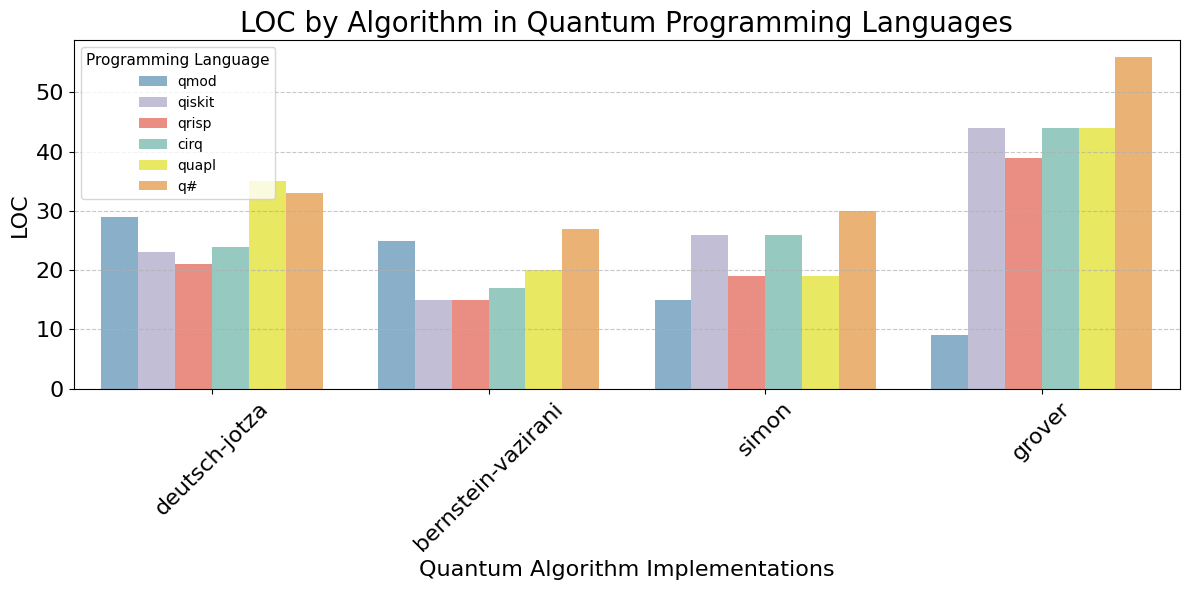

Plot saved at: results/graphics/cc_by_algorithm.png


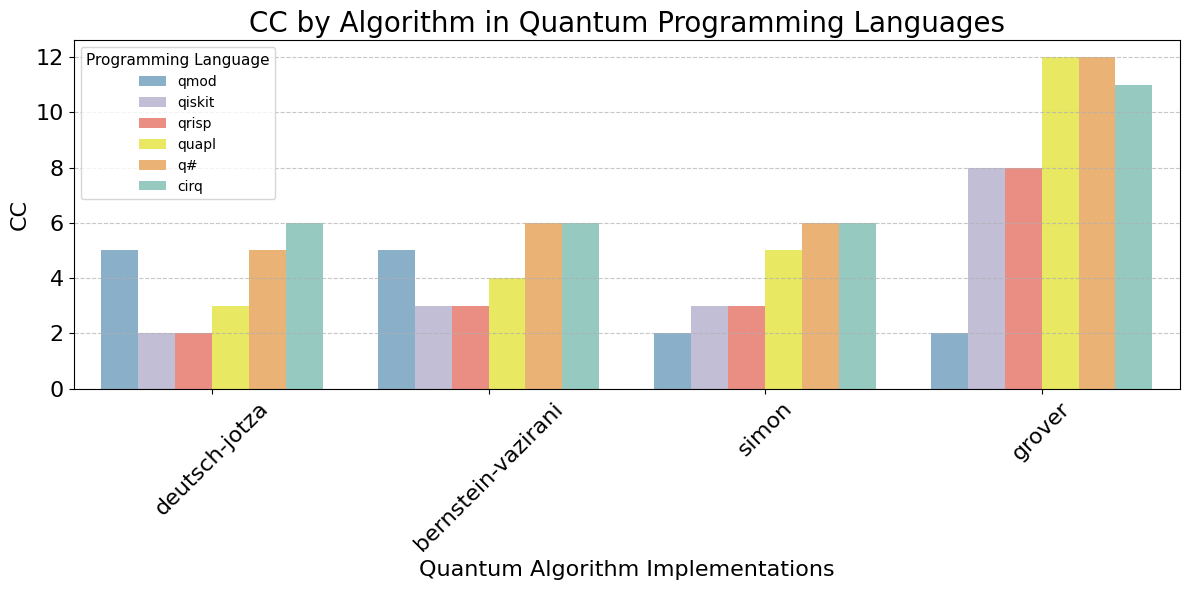

Plot saved at: results/graphics/mean_loc_by_algorithm.png


C:\Users\franc\AppData\Local\Temp\ipykernel_14856\350296205.py:109: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
C:\Users\franc\AppData\Local\Temp\ipykernel_14856\350296205.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


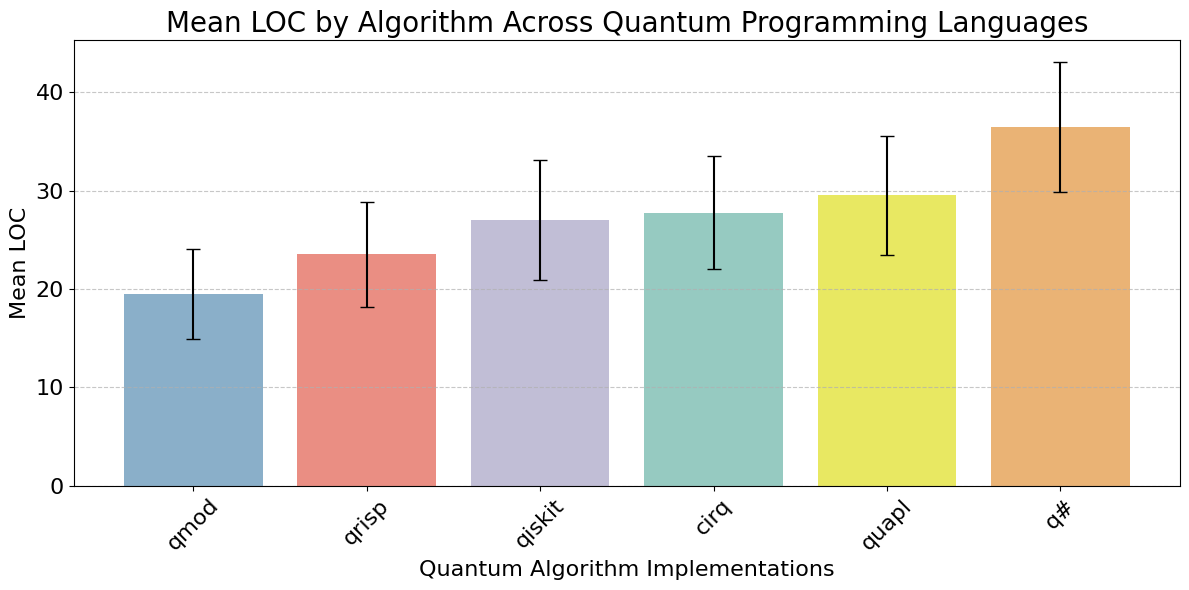

C:\Users\franc\AppData\Local\Temp\ipykernel_14856\350296205.py:109: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
C:\Users\franc\AppData\Local\Temp\ipykernel_14856\350296205.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Plot saved at: results/graphics/mean_cc_by_algorithm.png


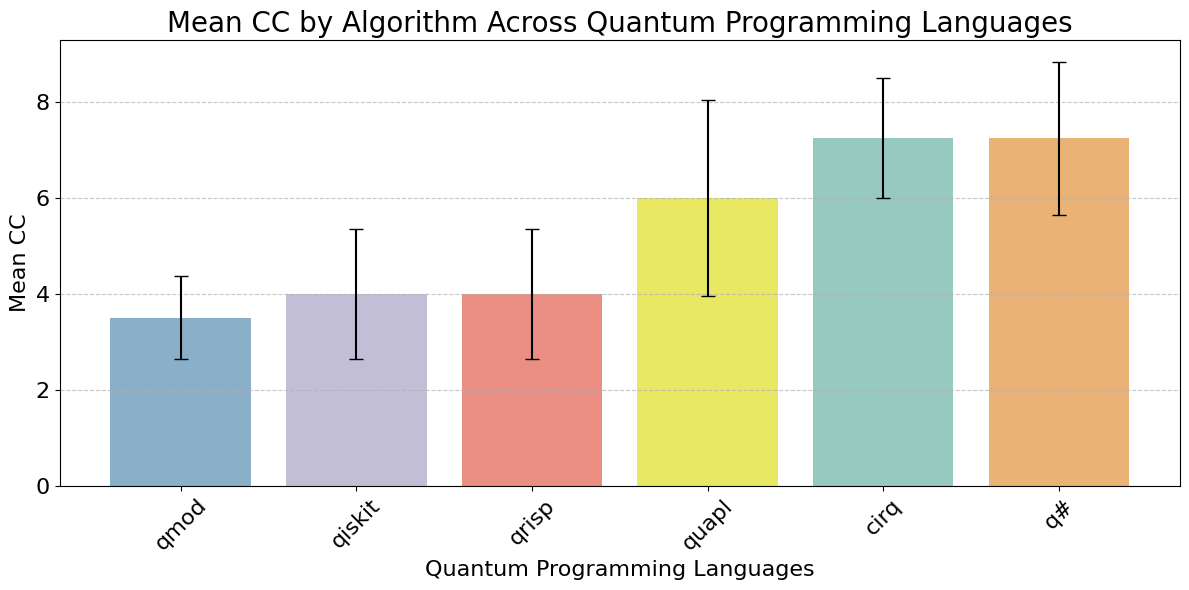

C:\Users\franc\AppData\Local\Temp\ipykernel_14856\350296205.py:109: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
C:\Users\franc\AppData\Local\Temp\ipykernel_14856\350296205.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Plot saved at: results/graphics/harmonic_loc_by_algorithm.png


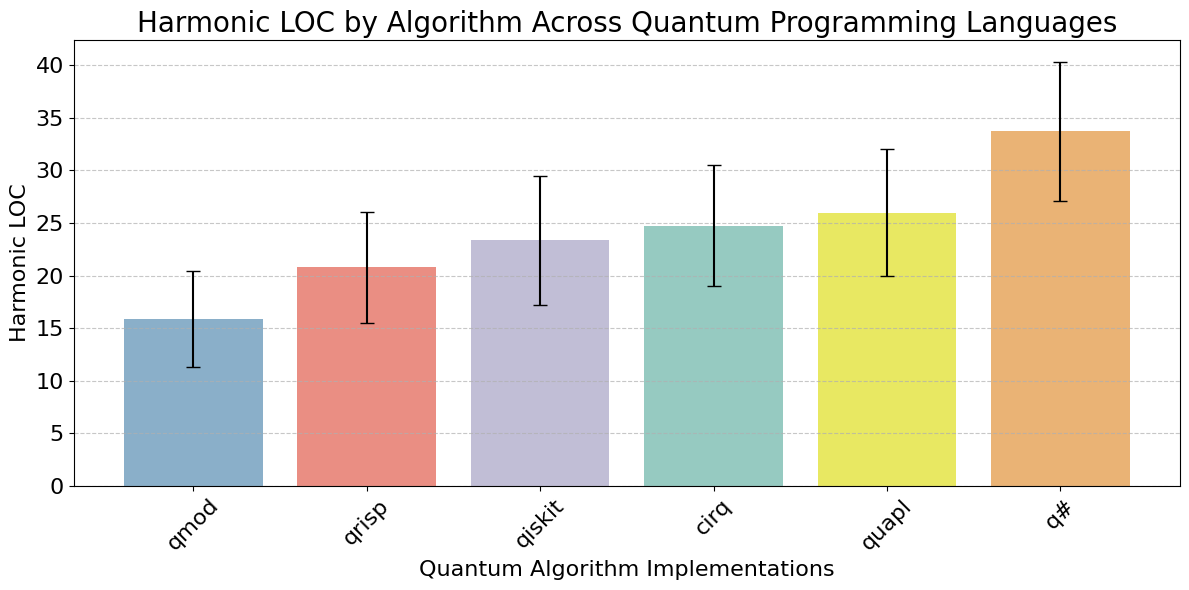

C:\Users\franc\AppData\Local\Temp\ipykernel_14856\350296205.py:109: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
C:\Users\franc\AppData\Local\Temp\ipykernel_14856\350296205.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Plot saved at: results/graphics/harmonic_cc_by_algorithm.png


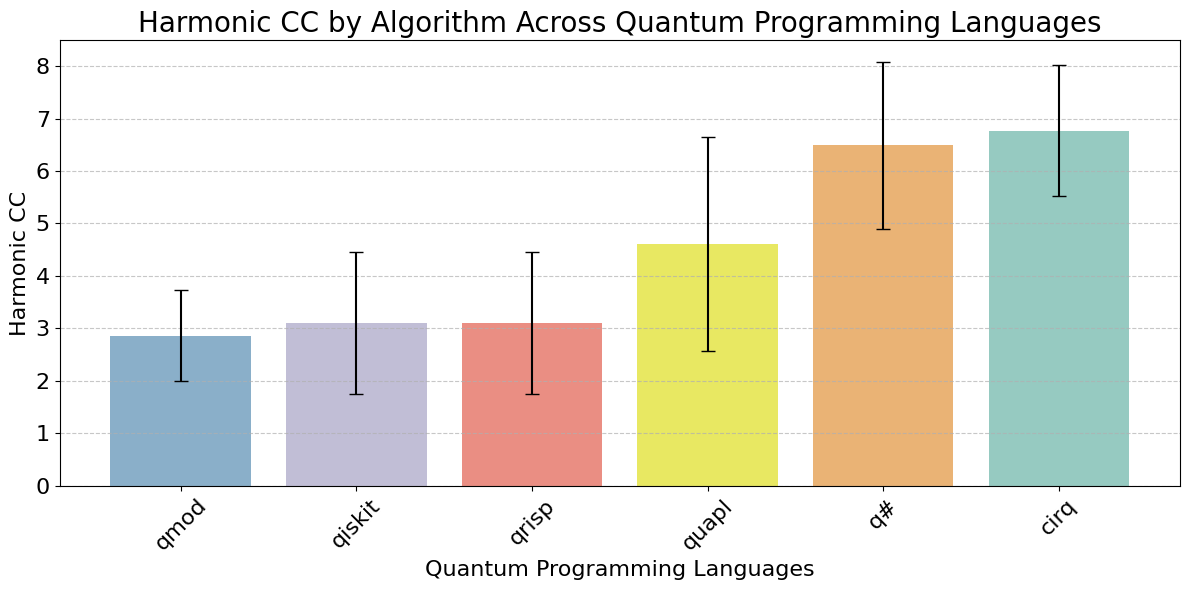

'\nanalyzer.run(language_type="hosted", chart_type=["loc_by_algorithm"], attributes={\n    \'title\': \'LOC by Algorithm Across Hosted Quantum Programming Languages\',\n    \'xlabel\': \'Quantum Algorithm Implementations\',\n    \'ylabel\': \'LOC\',\n})\n\nanalyzer.run(language_type="standalone", chart_type=["loc_by_algorithm"], attributes={\n    \'title\': \'Lines of Code by Algorithm Across Standalone Quantum Programming Languages\',\n    \'xlabel\': \'Quantum Algorithm Implementations\',\n    \'ylabel\': \'LOC\',\n})\n\n# CC por algoritmo - Hosted y Standalone\nanalyzer.run(language_type="hosted", chart_type=["cc_by_algorithm"], attributes={\n    \'title\': \'CC by Algorithm Across Hosted Quantum Programming Languages\',\n    \'xlabel\': \'Quantum Algorithm Implementations\',\n    \'ylabel\': \'CC\',\n})\n\nanalyzer.run(language_type="standalone", chart_type=["cc_by_algorithm"], attributes={\n    \'title\': \'CC by Algorithm Across Standalone Quantum Programming Languages\',\n    \'

In [65]:
# LOC y CC por algoritmo (todos los lenguajes)
analyzer.run(language_type="all", chart_type=["loc_by_algorithm"], attributes={
    'title': 'LOC by Algorithm in Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'LOC',
    'filename': 'loc_by_algorithm'
})

analyzer.run(language_type="all", chart_type=["cc_by_algorithm"], attributes={
    'title': 'CC by Algorithm in Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'CC',
    'filename': 'cc_by_algorithm'  
})


analyzer.run(language_type="all", chart_type=["loc_avg_by_algorithm"], attributes={
    'title': 'Mean LOC by Algorithm Across Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Mean LOC',
    'filename': 'mean_loc_by_algorithm'  
})

analyzer.run(language_type="all", chart_type=["cc_avg_by_algorithm"], attributes={
    'title': 'Mean CC by Algorithm Across Quantum Programming Languages',
    'xlabel': 'Quantum Programming Languages',
    'ylabel': 'Mean CC',
    'filename': 'mean_cc_by_algorithm'
})


analyzer.run(language_type="all", chart_type=["loc_avg_by_algorithm_harmonic"], attributes={
    'title': 'Harmonic LOC by Algorithm Across Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Harmonic LOC',
    'filename': 'harmonic_loc_by_algorithm'
})

analyzer.run(language_type="all", chart_type=["cc_avg_by_algorithm_harmonic"], attributes={
    'title': 'Harmonic CC by Algorithm Across Quantum Programming Languages',
    'xlabel': 'Quantum Programming Languages',
    'ylabel': 'Harmonic CC',
    'filename': 'harmonic_cc_by_algorithm'
})



# LOC por algoritmo - Hosted y Standalone
'''
analyzer.run(language_type="hosted", chart_type=["loc_by_algorithm"], attributes={
    'title': 'LOC by Algorithm Across Hosted Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'LOC',
})

analyzer.run(language_type="standalone", chart_type=["loc_by_algorithm"], attributes={
    'title': 'Lines of Code by Algorithm Across Standalone Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'LOC',
})

# CC por algoritmo - Hosted y Standalone
analyzer.run(language_type="hosted", chart_type=["cc_by_algorithm"], attributes={
    'title': 'CC by Algorithm Across Hosted Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'CC',
})

analyzer.run(language_type="standalone", chart_type=["cc_by_algorithm"], attributes={
    'title': 'CC by Algorithm Across Standalone Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'CC',
})

analyzer.run(language_type="hosted", chart_type=["loc_avg_by_algorithm"], attributes={
    'title': 'Mean LOC by Algorithm Across Hosted Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'LOC',
})

analyzer.run(language_type="standalone", chart_type=["loc_avg_by_algorithm"], attributes={
    'title': 'Mean LOC by Algorithm Across Standalone Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'LOC',
})

analyzer.run(language_type="hosted", chart_type=["cc_avg_by_algorithm"], attributes={
    'title': 'Mean CC by Algorithm Across Hosted Quantum Programming Languages',
    'xlabel': 'Hosted Quantum Programming Languages',
    'ylabel': 'Mean CC',
})

analyzer.run(language_type="standalone", chart_type=["cc_avg_by_algorithm"], attributes={
    'title': 'Mean CC by Algorithm Across Standalone Quantum Programming Languages',
    'xlabel': 'Standalone Quantum Programming Languages',
    'ylabel': 'Mean CC',
})
'''


Plot saved at: results/graphics/radar_all_languages.png


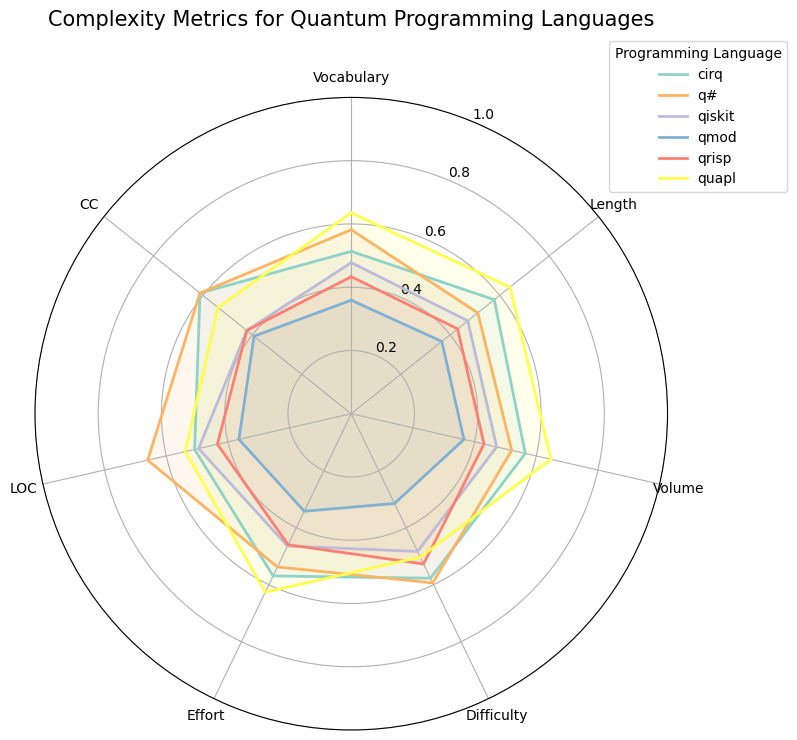

In [66]:
#analyzer.run(language_type="hosted", chart_type=["radar"], attributes={'title': 'Complexity Metrics for Hosted Quantum Programming Languages'})
#analyzer.run(language_type="standalone", chart_type=["radar"], attributes={'title': 'Complexity Metrics for Standalone Quantum Programming Languages'})
analyzer.run(language_type="all", chart_type=["radar"], attributes={'title': 'Complexity Metrics for Quantum Programming Languages', 'filename': 'radar_all_languages'})

In [67]:
#analyzer.run(language_type="all", chart_type=["loc_vs_cc"], attributes={"title": "Lines of Code vs Cyclomatic Complexity Across Quantum Programming Languages"})

Plot saved at: results/graphics/10_scatter_matrix_metrics.png


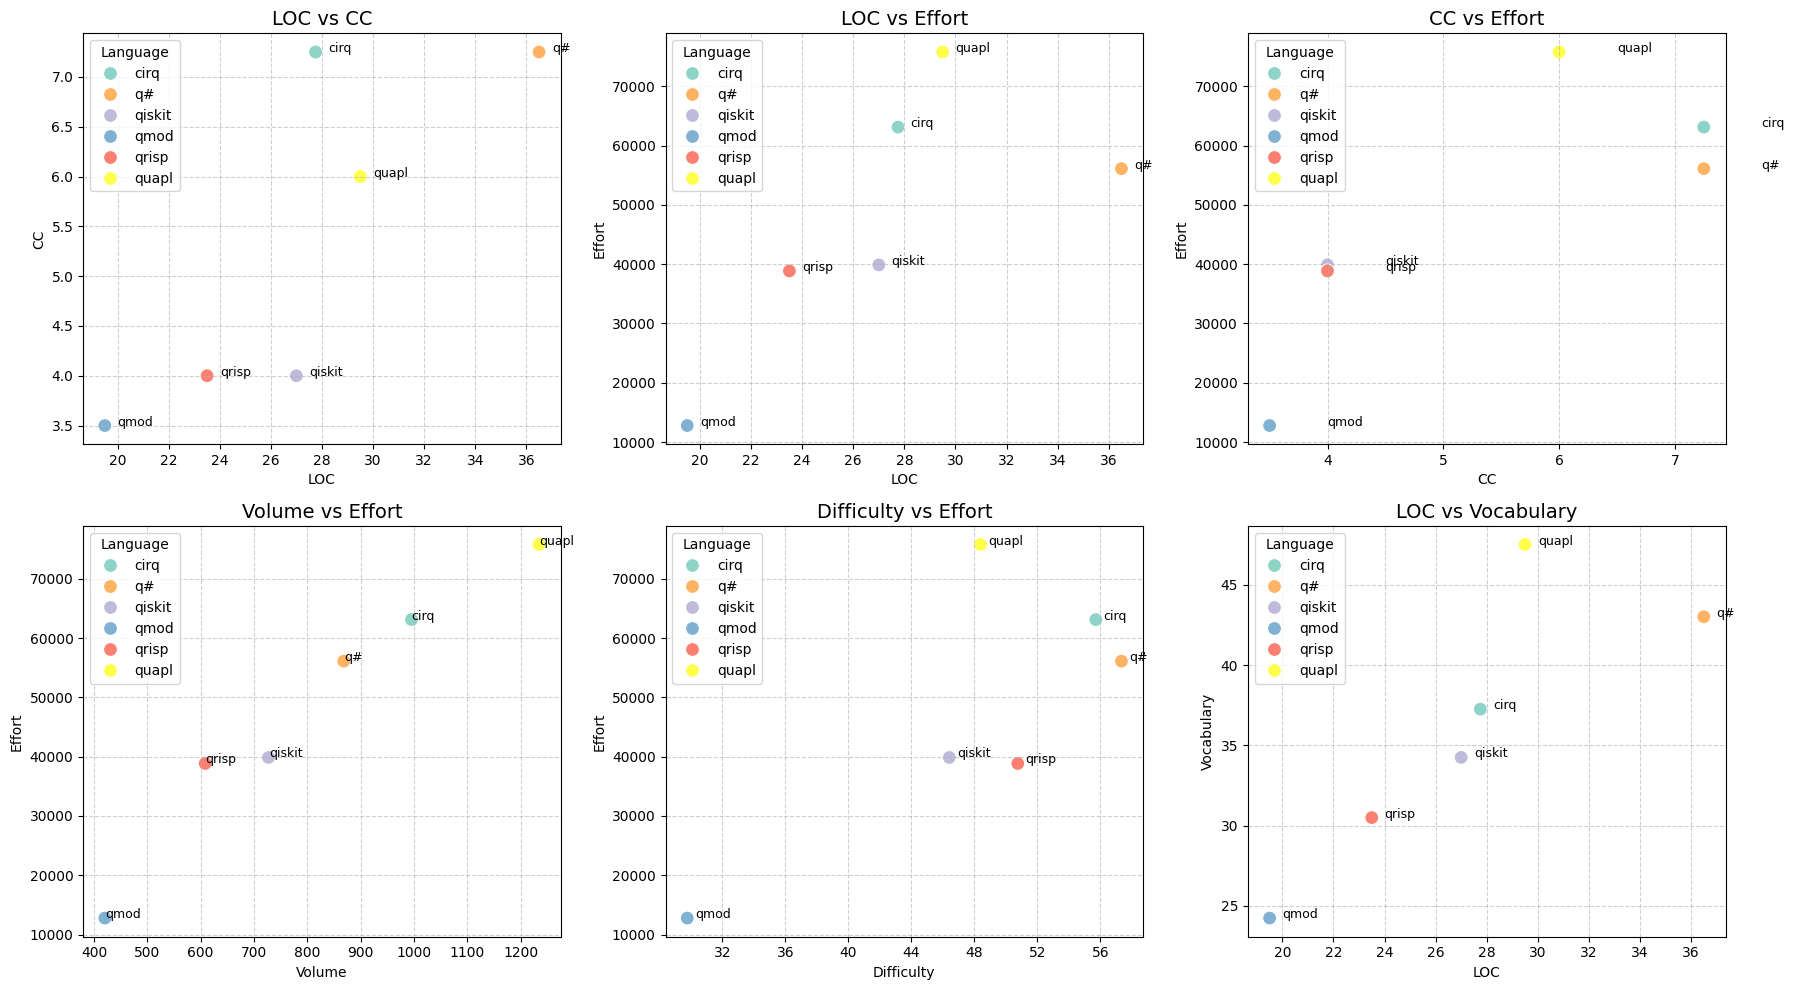

In [68]:
analyzer.run(language_type="all", chart_type="scatter_matrix")

Plot saved at: results/graphics/12_scatter_cloud_by_language.png


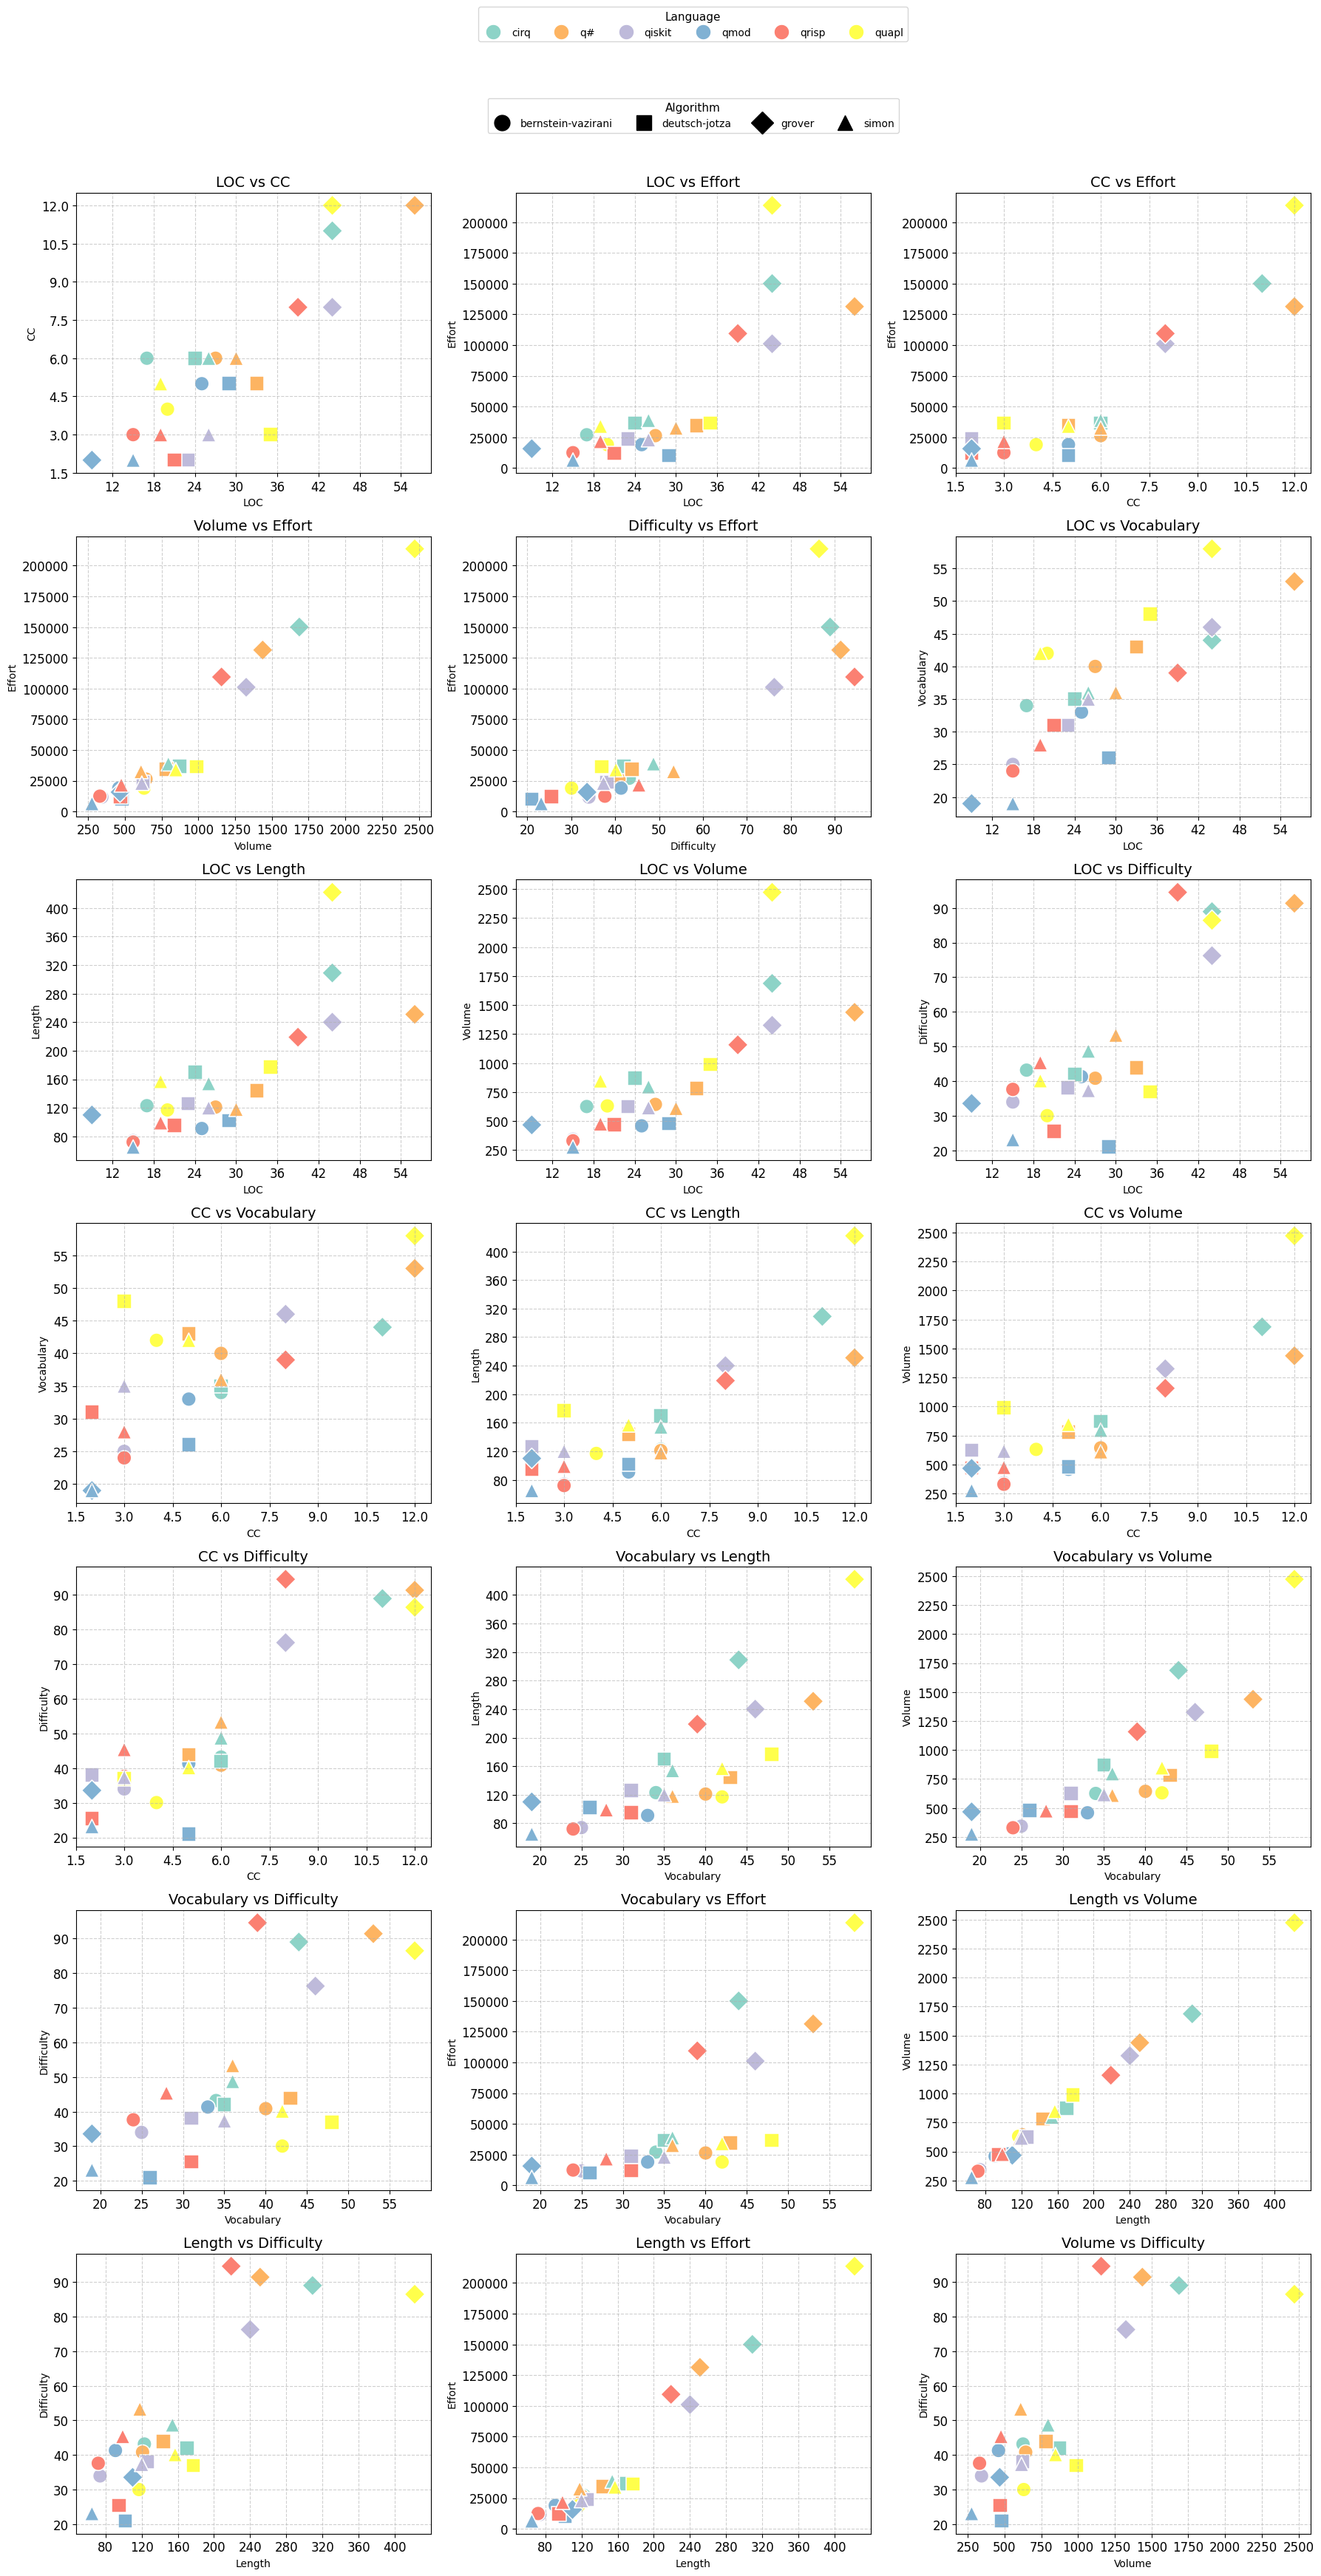

In [69]:
analyzer.run(language_type="all", chart_type="scatter_matrix_algorithm")

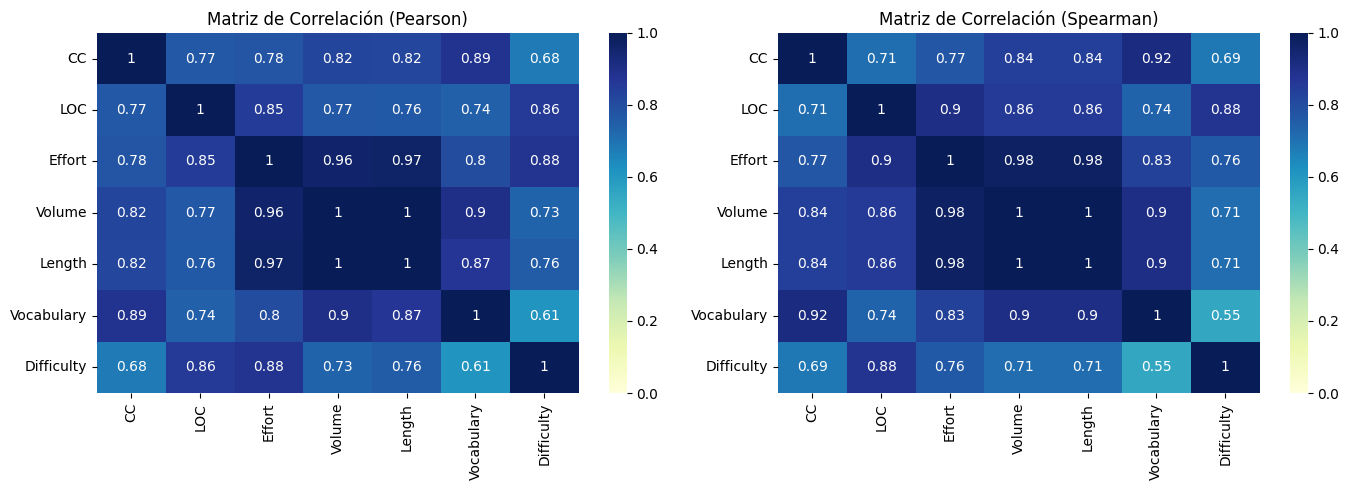

In [70]:
df = mean_data_master
metrics = ["CC","LOC", "Effort", "Volume", "Length", "Vocabulary", "Difficulty"]
numeric_df = df[metrics]
pearson_corr_matrix = numeric_df.corr(method="pearson")
spearman_corr_matrix = numeric_df.corr(method="spearman")
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.heatmap(pearson_corr_matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
plt.title("Matriz de Correlación (Pearson)")
plt.subplot(1, 2, 2)
sns.heatmap(spearman_corr_matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
plt.title("Matriz de Correlación (Spearman)")
plt.tight_layout()
plt.show()

In [71]:
df = df.drop(columns=["Language"])

In [72]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Supongamos que tienes un DataFrame X con las variables independientes
vif = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif

[35.10536871133,
 86.56721839696787,
 1400.7970200341697,
 12324.898028939038,
 25996.80570697535,
 727.1901807890699,
 2164.2245577895055]